In [1]:
import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
from popsims.plot_style import  plot_style
from astropy.coordinates import SkyCoord
import astropy.coordinates as astro_coord
import astropy.units as u
from tqdm import tqdm
import popsims
import pandas as pd
from easyshapey import Box

plot_style()

path_isochrone='../data/isochrones/'
path_data='../data/images/'
path_streamdata='../data/stream/'
path_pipeline='../data/pipeline/'
path_pandas= '../data/pandas/'

In [17]:
rgc='10_20'
d_m31= 770*u.kpc
dmod_m31=5*np.log10(d_m31.to(u.pc).value/10.0)
mag_limit=28.54
N_pal5=3000
mhalo=5e6
vhalo=-50

d_galaxy=770*u.kpc
dmod_galaxy=5*np.log10(d_galaxy.to(u.pc).value/10.0)
dmod_diff= dmod_galaxy-dmod_m31

kpc_conversion = np.pi * d_galaxy / 180.
roman_fov= 0.52*u.degree*(kpc_conversion /u.degree)

gap_centers={'10_20': (2.5, 7.)}
rotation_angles={'10_20': -15.*u.degree.to(u.radian)}

In [18]:
#read stream
def read_stream_file(gap_center, box, rgc, mhalo, vhalo, rotate_by=-np.pi/8):
    
    filename='pal5_rgc{}_mhalo{:.2e}_vhalo{:.0f}'.format(rgc, mhalo, vhalo)
    st=(np.load(path_streamdata+'/{}.npy'.format(filename), allow_pickle=True).flatten()[0])['stream']
    
    x=st.y.value
    y=st.x.value
    
    x0, y0= rotate(x0, y0, rotate_by, c=(np.nanmedian(x0), np.nanmedian(y0)))
    
    center=np.nanmedian(np.array(rgc.split('_')).astype(float))
     
    x0=x-(gap_center[0]-center)
    y0=y-(gap_center[1]-center)
    
    #first rotate to 0 
   
    
    choose=np.random.choice(np.arange(len(x0)), N_pal5)
    
    selected=box.select(np.array([x0[choose], y0[choose]]))
    
    x=selected[0]
    y=selected[1]
    
    return [x, y]
    
def read_cmd_file(rgc, dmod_diff, mag_limit):
    fname=path_isochrone+'simulated_df_at_M31_normalized_extended_rgc{}.csv'.format(rgc)
    df=pd.read_csv(fname)
    
    #put to the desired distance modulus 
    mw_df= df.query("galaxy == 'MW'").reset_index(drop=True)
    m31_df= df.query("galaxy =='M31'").reset_index(drop=True)
    
    for k in ['appF062mag', 'appF087mag', 'appgmag', 'appimag']:
         m31_df[k]=  m31_df[k].values+dmod_diff
            
    #appply magnitude cut
    df_final=pd.concat([m31_df, mw_df]).reset_index(drop=True)
    df_final=(df_final[df_final.appF087mag < mag_limit]).reset_index(drop=True)
    
    
    #assign RA, DEC, xki based on the data
    from astropy.io.votable import parse_single_table
    data=parse_single_table(path_pandas+'M31_{}kpc_new.vot'.format(rgc)).to_table().to_pandas()
    
    
    for k in ['RA', 'Dec','xki', 'eta']:
        df_final[k]=np.random.choice(data[k].values, len(df_final), replace=True)
              
    s=SkyCoord(ra=df_final.RA, dec=df_final.Dec,frame = 'icrs', unit = (u.hourangle, u.deg))
    
    center=np.nanmedian(np.array(rgc.split('_')).astype(float))
              
    shift_x=np.nanmedian(kpc_conversion.value*(s.ra.to(u.degree).value))-center
    shift_y=np.nanmedian(kpc_conversion.value*(s.dec.to(u.degree).value))-center
    
    df_final['x_coord']=kpc_conversion.value*(s.ra.to(u.degree).value)-shift_x
    df_final['y_coord']=kpc_conversion.value*(s.dec.to(u.degree).value)-shift_y
    
    return df_final

In [19]:
#df=read_cmd_file(rgc, dmod_diff, mag_limit)

In [20]:
def make_box(center, xextent, yextent):
    b=Box()
    x_min, x_max =center[0]- xextent/2, center[0]+ xextent/2
    y_min, y_max =center[-1]- yextent/2, center[-1]+ yextent/2
    v1= (x_min, y_min)
    v2=(x_min, y_max)
    v4= (x_max, y_min)
    v3=(x_max,y_max)

    b.vertices=[v1, v2, v3, v4, v1]
    return b

def rotate(x, y, ang, c=(0,0)):
    """
    Angle must be in radians
    """
    
    #rotation matrix
    r=[[np.cos(ang), -np.sin(ang)],
       [np.sin(ang), np.cos(ang)]]
    
    i=np.identity(2)
    
    mat=np.matrix([[r[0][0], r[0][1], np.dot(i-r, c)[0]],
                   [r[1][0], r[1][1], np.dot(i-r, c)[1]],
                   [0., 0., 1.]])

    z=np.ones_like(x)
    
    rotated=np.array(np.dot(mat, np.array([x, y, z])))
    
    return rotated[0], rotated[1] 

In [21]:
center=np.nanmedian(np.array(rgc.split('_')).astype(float))
b=make_box( (center, center),20, 20)

In [22]:
vls=read_stream_file(gap_centers[rgc], b, rgc, mhalo, vhalo, rotate_by=rotation_angles[rgc])

[(13.5, 14.4), (12.0, 18.0)]

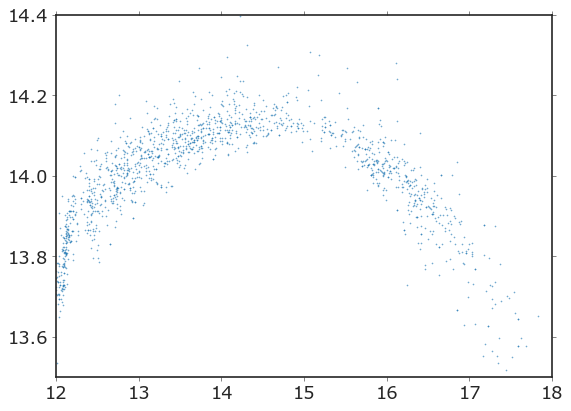

In [23]:
fig, ax=plt.subplots()
ax.scatter(vls[0], vls[1], s=.1)
ax.set(ylim=[13.5, 14.4], xlim=[12, 18])

In [25]:
filename='pal5_rgc{}_mhalo{:.2e}_vhalo{:.0f}'.format(rgc, mhalo, vhalo)
st=(np.load(path_streamdata+'/{}.npy'.format(filename), allow_pickle=True).flatten()[0])['stream']

x=st.y.value
y=st.x.value

[(0.0, 4.0), (5.5, 8.0)]

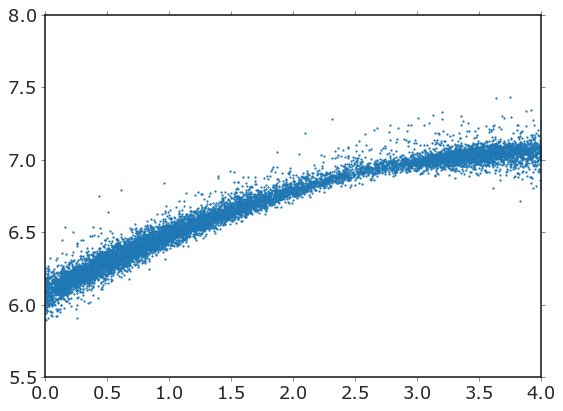

In [32]:
fig, ax=plt.subplots()
ax.scatter(x, y, s=1)
ax.set(xlim=[0, 4], ylim=[5.5, 8])
ax.scatter()